<center><h1>Ye_Yutao_Final Project</h1></center>

Name: Yutao Ye
<br>
Github Username: leo-ye0
<br>
USC ID: 2448443089

## 1. Text Classification

import packages

In [1]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python import keras
from keras.preprocessing.text import Tokenizer
import os
import string
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout, Activation, Conv1D, MaxPooling1D, LSTM, Bidirectional
from keras.optimizers.legacy import Adam
from keras.losses import MeanSquaredError

### (a) Download the Data Set

In [2]:
def load_txt(folder,label, start, end):
    data = []
    filenames = sorted(os.listdir(folder))
    for filename in filenames[start:end]:
        with open(os.path.join(folder, filename), 'r') as file:
            text = file.read()
            for line in text.split('\n'):
                data.append([line,label])
    return data

neg_path = '../data/neg'
pos_path = '../data/pos'

### (b) Data Exploration and Pre-processing

i. use binary encoding for sentiments(1,-1) & iii. Split train test.

In [3]:
positive_train = load_txt(pos_path,1,0,700)
negative_train = load_txt(neg_path,-1,0,700)
positive_test = load_txt(pos_path,1,700,1000)
negative_test = load_txt(neg_path,-1,700,1000)

pos_train = pd.DataFrame(positive_train, columns=['text', 'sentiment'])
neg_train = pd.DataFrame(negative_train, columns=['text', 'sentiment'])
pos_test = pd.DataFrame(positive_test, columns=['text', 'sentiment'])
neg_test = pd.DataFrame(negative_test, columns=['text', 'sentiment'])

pos_train = pos_train[pos_train['text'].str.strip().astype(bool)]
neg_train = neg_train[neg_train['text'].str.strip().astype(bool)]
pos_test = pos_test[pos_test['text'].str.strip().astype(bool)]
neg_test = neg_test[neg_test['text'].str.strip().astype(bool)]

ii. Remove the punctuation and numbers from the data.

In [4]:
def clean_data(text):
    translator = str.maketrans('', '', string.punctuation + string.digits)
    return text.translate(translator)

pos_train['text'] = pos_train['text'].apply(clean_data)
neg_train['text'] = neg_train['text'].apply(clean_data)
pos_test['text'] = pos_test['text'].apply(clean_data)
neg_test['text'] = neg_test['text'].apply(clean_data)

iv. Count the number of unique words in the whole dataset.

In [5]:
df_train = pd.concat([pos_train, neg_train])
df_test = pd.concat([pos_test, neg_test])
df = pd.concat([df_train, df_test])
# print(df_train.head())
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
unique_cnt = len(tokenizer.word_index)
print('The number of unique words in the whole dataset is ' + str(unique_cnt) + '.')


The number of unique words in the whole dataset is 46830.


v. Calculate the average review length and the standard deviation of review lengths.

In [6]:
review_lengths = [len(review.split()) for review in df['text']]
avg_length = np.mean(review_lengths)
std_length = np.std(review_lengths)
print('The average review length:', avg_length)
print('The standard deviation of the review length:', std_length)


The average review length: 19.91209826946848
The standard deviation of the review length: 11.821401502509953


vi. Plot the histogram of review lengths.

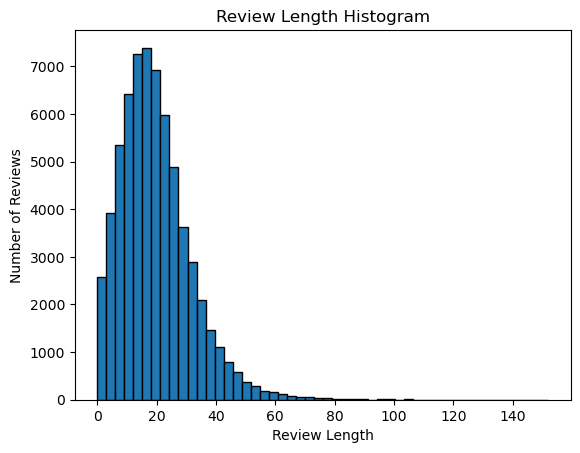

In [7]:
plt.hist(review_lengths, edgecolor='black', bins=50)
plt.xlabel('Review Length')
plt.ylabel('Number of Reviews')
plt.title('Review Length Histogram')
plt.show()

vii. Tokenization

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['text'])
tok_df = tokenizer.texts_to_sequences(df['text'])
tok_train = tokenizer.texts_to_sequences(df_train['text'])
tok_test = tokenizer.texts_to_sequences(df_test['text'])

viii. Select a review length L that 70% of the reviews have a length below it.

In [9]:
L = np.percentile(review_lengths, 70)
print('L:', L)

L: 24.0


iv. Truncate and zero-pad

In [10]:
pad_train = pad_sequences(tok_train, maxlen = int(L), padding = 'post', truncating = 'post')
pad_test = pad_sequences(tok_test, maxlen = int(L), padding = 'post', truncating = 'post')
pad_df = pad_sequences(tok_df, maxlen = int(L), padding = 'post', truncating = 'post')

pad_train[-8]


array([   16,     1,   567,     6,    39, 21091,     8,    56,     2,
        5519,    21,  2626,  1675,   661,   260,     9,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)

### (c) Word Embeddings

i. Word Embedding

In [11]:
top_words = 5000
max_words = int(L) 
embed_vector_length = 32

model = Sequential()
model.add(Embedding(top_words+1, embed_vector_length, input_length=max_words, mask_zero=True))


2024-05-01 20:37:19.796323: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-05-01 20:37:19.796351: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-05-01 20:37:19.796357: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-05-01 20:37:19.796607: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-01 20:37:19.796631: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


ii. Flatten the matrix

In [12]:
model.add(Flatten())

### (d) Multi-Layer Perceptron

i. Train a MLP

In [13]:
hidden_units = 50
epoch = 2
batch_size = 10

df_train['sentiment'] = df_train['sentiment'].replace(-1, 0)
df_test['sentiment'] = df_test['sentiment'].replace(-1, 0)

model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

X = model.fit(pad_train, df_train['sentiment'], epochs=epoch, batch_size=batch_size, validation_data=(pad_test, df_test['sentiment']))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 24, 32)            160032    
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 50)                38450     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                2

2024-05-01 20:37:24.050289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4530/4530 [==============================] - ETA: 0s - loss: 0.6697 - accuracy: 0.5852

2024-05-01 20:38:03.114308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4530/4530 [==============================] - 45s 10ms/step - loss: 0.6697 - accuracy: 0.5852 - val_loss: 0.6555 - val_accuracy: 0.6137
Epoch 2/2
4530/4530 [==============================] - 43s 10ms/step - loss: 0.6005 - accuracy: 0.6755 - val_loss: 0.6530 - val_accuracy: 0.6165


ii. Report the train and test accuracies of this model

In [14]:
train_loss, train_accuracy = model.evaluate(pad_train, df_train['sentiment'])
test_loss, test_accuracy = model.evaluate(pad_test, df_test['sentiment'])

print('Train accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)

608/608 [==============================] - 2s 3ms/step - loss: 0.6530 - accuracy: 0.6165
Train accuracy: 0.744762122631073
Test accuracy: 0.6164736151695251


### (e) One-Dimensional Convolutional Neural Network:

i. CNN

In [15]:
top_words = 5000
L = np.percentile(review_lengths, 70)
max_words = int(L) 
embed_vector_length = 32
hidden_units = 50
epoch = 2
batch_size = 10

pad_train = pad_sequences(tok_train, maxlen = int(L), padding = 'post', truncating = 'post')
pad_test = pad_sequences(tok_test, maxlen = int(L), padding = 'post', truncating = 'post')
pad_df = pad_sequences(tok_df, maxlen = int(L), padding = 'post', truncating = 'post')

model = Sequential()
model.add(Embedding(top_words+1, embed_vector_length, input_length=max_words, mask_zero=True))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2,strides=2))
model.add(Flatten())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

X = model.fit(pad_train, df_train['sentiment'], epochs=epoch, batch_size=batch_size, validation_data=(pad_test, df_test['sentiment']))



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 24, 32)            160032    
                                                                 
 conv1d (Conv1D)             (None, 22, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1  (None, 11, 32)            0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 352)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                17650     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                      

2024-05-01 20:39:05.727680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4530/4530 [==============================] - ETA: 0s - loss: 0.6799 - accuracy: 0.5652

2024-05-01 20:39:48.318178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4530/4530 [==============================] - 49s 11ms/step - loss: 0.6799 - accuracy: 0.5652 - val_loss: 0.6716 - val_accuracy: 0.5946
Epoch 2/2
4530/4530 [==============================] - 47s 10ms/step - loss: 0.6596 - accuracy: 0.6170 - val_loss: 0.6797 - val_accuracy: 0.5956


ii. Report the train and test accuracies of this model

In [16]:
train_loss, train_accuracy = model.evaluate(pad_train, df_train['sentiment'])
test_loss, test_accuracy = model.evaluate(pad_test, df_test['sentiment'])

print('Train accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)

608/608 [==============================] - 2s 4ms/step - loss: 0.6797 - accuracy: 0.5956
Train accuracy: 0.6630312204360962
Test accuracy: 0.5955727100372314


Trying to find better model, leaky relu performs better. Increasing epoch will lead to overfit. Add one more hidden layer.

In [17]:
L = np.percentile(review_lengths, 70)
top_words = 7000
max_words = int(L) 
embed_vector_length = 32
hidden_units = 50
epoch = 2
batch_size = 10

pad_train = pad_sequences(tok_train, maxlen = int(L), padding = 'post', truncating = 'post')
pad_test = pad_sequences(tok_test, maxlen = int(L), padding = 'post', truncating = 'post')
pad_df = pad_sequences(tok_df, maxlen = int(L), padding = 'post', truncating = 'post')

model = Sequential()
model.add(Embedding(top_words+1, embed_vector_length, input_length=max_words, mask_zero=True))
model.add(Conv1D(filters=32, kernel_size=3, activation='leaky_relu'))
model.add(MaxPooling1D(pool_size=2,strides=2))
model.add(Flatten())
model.add(Dense(hidden_units, activation='leaky_relu'))
model.add(Dropout(0.2))
model.add(Dense(hidden_units, activation='leaky_relu'))
model.add(Dropout(0.5))
model.add(Dense(hidden_units, activation='leaky_relu'))
model.add(Dropout(0.5))
model.add(Dense(hidden_units, activation='leaky_relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

X = model.fit(pad_train, df_train['sentiment'], epochs=epoch, batch_size=batch_size, validation_data=(pad_test, df_test['sentiment']))

train_loss, train_accuracy = model.evaluate(pad_train, df_train['sentiment'])
test_loss, test_accuracy = model.evaluate(pad_test, df_test['sentiment'])

print('Train accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 24, 32)            224032    
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 11, 32)            0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 352)               0         
                                                                 
 dense_8 (Dense)             (None, 50)                17650     
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                      

2024-05-01 20:40:54.518069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4530/4530 [==============================] - ETA: 0s - loss: 0.6498 - accuracy: 0.6112

2024-05-01 20:41:42.498425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4530/4530 [==============================] - 55s 12ms/step - loss: 0.6498 - accuracy: 0.6112 - val_loss: 0.6425 - val_accuracy: 0.6294
Epoch 2/2
608/608 [==============================] - 2s 4ms/step - loss: 0.6485 - accuracy: 0.6215
Train accuracy: 0.8274644017219543
Test accuracy: 0.6215186715126038


### (f) Long Short-Term Memory Recurrent Neural Network

i. LSTM

10 epochs

In [21]:
L = np.percentile(review_lengths, 70)
top_words = 5000
max_words = int(L) 
embed_vector_length = 32
lstm_units = 256
epoch = 10
batch_size = 10

pad_train = pad_sequences(tok_train, maxlen = int(L), padding = 'post', truncating = 'post')
pad_test = pad_sequences(tok_test, maxlen = int(L), padding = 'post', truncating = 'post')
pad_df = pad_sequences(tok_df, maxlen = int(L), padding = 'post', truncating = 'post')

model = Sequential()
model.add(Embedding(top_words+1, embed_vector_length, input_length=max_words, mask_zero=True))
model.add(LSTM(lstm_units, dropout=0.2, return_sequences=False))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

X = model.fit(pad_train, df_train['sentiment'], epochs=epoch, batch_size=batch_size, validation_data=(pad_test, df_test['sentiment']))



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 24, 32)            160032    
                                                                 
 lstm_3 (LSTM)               (None, 256)               295936    
                                                                 
 dense_19 (Dense)            (None, 256)               65792     
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_20 (Dense)            (None, 1)                 257       
                                                                 
Total params: 522017 (1.99 MB)
Trainable params: 522017 (1.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10


2024-05-01 22:28:51.609191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 22:28:51.889182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 22:28:52.275822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4530/4530 [==============================] - ETA: 0s - loss: 0.6651 - accuracy: 0.5857

2024-05-01 22:31:21.923565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 22:31:22.050673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4530/4530 [==============================] - 169s 37ms/step - loss: 0.6651 - accuracy: 0.5857 - val_loss: 0.6514 - val_accuracy: 0.6227
Epoch 2/10
4530/4530 [==============================] - 164s 36ms/step - loss: 0.5888 - accuracy: 0.6863 - val_loss: 0.6586 - val_accuracy: 0.6299
Epoch 3/10
4530/4530 [==============================] - 162s 36ms/step - loss: 0.5522 - accuracy: 0.7139 - val_loss: 0.6639 - val_accuracy: 0.6233
Epoch 4/10
4530/4530 [==============================] - 160s 35ms/step - loss: 0.5236 - accuracy: 0.7301 - val_loss: 0.6983 - val_accuracy: 0.6174
Epoch 5/10
4530/4530 [==============================] - 159s 35ms/step - loss: 0.4993 - accuracy: 0.7412 - val_loss: 0.7573 - val_accuracy: 0.6051
Epoch 6/10
4530/4530 [==============================] - 161s 36ms/step - loss: 0.4799 - accuracy: 0.7511 - val_loss: 0.7495 - val_accuracy: 0.6214
Epoch 7/10
4530/4530 [==============================] - 164s 36ms/step - loss: 0.4657 - accuracy: 0.7573 - val_loss: 0.7690 - val

In [24]:
train_loss, train_accuracy = model.evaluate(pad_train, df_train['sentiment'])
test_loss, test_accuracy = model.evaluate(pad_test, df_test['sentiment'])

print('Train accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)

608/608 [==============================] - 18s 30ms/step - loss: 0.6973 - accuracy: 0.6090
Train accuracy: 0.737873911857605
Test accuracy: 0.6090090274810791


5 epochs

In [19]:
L = np.percentile(review_lengths, 70)
top_words = 5000
max_words = int(L) 
embed_vector_length = 32
lstm_units = 256
epoch = 5
batch_size = 10

pad_train = pad_sequences(tok_train, maxlen = int(L), padding = 'post', truncating = 'post')
pad_test = pad_sequences(tok_test, maxlen = int(L), padding = 'post', truncating = 'post')
pad_df = pad_sequences(tok_df, maxlen = int(L), padding = 'post', truncating = 'post')

model = Sequential()
model.add(Embedding(top_words+1, embed_vector_length, input_length=max_words, mask_zero=True))
model.add(Bidirectional(LSTM(lstm_units, dropout=0.2, return_sequences=False)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

X = model.fit(pad_train, df_train['sentiment'], epochs=epoch, batch_size=batch_size, validation_data=(pad_test, df_test['sentiment']))

train_loss, train_accuracy = model.evaluate(pad_train, df_train['sentiment'])
test_loss, test_accuracy = model.evaluate(pad_test, df_test['sentiment'])

print('Train accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 24, 32)            160032    
                                                                 
 bidirectional_1 (Bidirecti  (None, 512)               591872    
 onal)                                                           
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 257       
                                                                 
Total params: 883489 (3.37 MB)
Trainable params: 883489 (3.37 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

2024-05-01 21:00:21.391735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 21:00:21.831584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 21:00:21.960951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 21:00:22.266205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 21:00:22.402042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4530/4530 [==============================] - ETA: 0s - loss: 0.6618 - accuracy: 0.5932

2024-05-01 21:05:21.749173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 21:05:21.954451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 21:05:22.014744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4530/4530 [==============================] - 341s 75ms/step - loss: 0.6618 - accuracy: 0.5932 - val_loss: 0.6457 - val_accuracy: 0.6268
Epoch 2/5
4530/4530 [==============================] - 336s 74ms/step - loss: 0.5869 - accuracy: 0.6882 - val_loss: 0.6423 - val_accuracy: 0.6269
Epoch 3/5
4530/4530 [==============================] - 332s 73ms/step - loss: 0.5512 - accuracy: 0.7116 - val_loss: 0.6653 - val_accuracy: 0.6280
Epoch 4/5
4530/4530 [==============================] - 327s 72ms/step - loss: 0.5197 - accuracy: 0.7319 - val_loss: 0.6620 - val_accuracy: 0.6204
Epoch 5/5
608/608 [==============================] - 17s 28ms/step - loss: 0.7606 - accuracy: 0.6168
Train accuracy: 0.7531294822692871
Test accuracy: 0.6167824864387512


20 epochs

In [26]:
L = np.percentile(review_lengths, 70)
top_words = 5000
max_words = int(L) 
embed_vector_length = 32
lstm_units = 256
epoch = 20
batch_size = 10

pad_train = pad_sequences(tok_train, maxlen = int(L), padding = 'post', truncating = 'post')
pad_test = pad_sequences(tok_test, maxlen = int(L), padding = 'post', truncating = 'post')
pad_df = pad_sequences(tok_df, maxlen = int(L), padding = 'post', truncating = 'post')

model = Sequential()
model.add(Embedding(top_words+1, embed_vector_length, input_length=max_words, mask_zero=True))
model.add(Bidirectional(LSTM(lstm_units, dropout=0.2, return_sequences=False)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

X = model.fit(pad_train, df_train['sentiment'], epochs=epoch, batch_size=batch_size, validation_data=(pad_test, df_test['sentiment']))

train_loss, train_accuracy = model.evaluate(pad_train, df_train['sentiment'])
test_loss, test_accuracy = model.evaluate(pad_test, df_test['sentiment'])

print('Train accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 24, 32)            160032    
                                                                 
 bidirectional_5 (Bidirecti  (None, 512)               591872    
 onal)                                                           
                                                                 
 dense_27 (Dense)            (None, 256)               131328    
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_28 (Dense)            (None, 1)                 257       
                                                                 
Total params: 883489 (3.37 MB)
Trainable params: 883489 (3.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

2024-05-02 00:04:12.644973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-02 00:04:13.132687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-02 00:04:13.285082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-02 00:04:13.759041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-02 00:04:13.898419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4530/4530 [==============================] - ETA: 0s - loss: 0.6581 - accuracy: 0.6010

2024-05-02 00:09:36.771264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-02 00:09:36.987884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-02 00:09:37.059050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4530/4530 [==============================] - 370s 81ms/step - loss: 0.6581 - accuracy: 0.6010 - val_loss: 0.6451 - val_accuracy: 0.6299
Epoch 2/20
4530/4530 [==============================] - 356s 79ms/step - loss: 0.5830 - accuracy: 0.6907 - val_loss: 0.6558 - val_accuracy: 0.6241
Epoch 3/20
4530/4530 [==============================] - 357s 79ms/step - loss: 0.5489 - accuracy: 0.7126 - val_loss: 0.6609 - val_accuracy: 0.6244
Epoch 4/20
4530/4530 [==============================] - 357s 79ms/step - loss: 0.5377 - accuracy: 0.7162 - val_loss: 0.6901 - val_accuracy: 0.6169
Epoch 5/20
4530/4530 [==============================] - 356s 79ms/step - loss: 0.5563 - accuracy: 0.7069 - val_loss: 0.6843 - val_accuracy: 0.6183
Epoch 6/20
4530/4530 [==============================] - 354s 78ms/step - loss: 0.5800 - accuracy: 0.6985 - val_loss: 0.7157 - val_accuracy: 0.6119
Epoch 7/20
4530/4530 [==============================] - 355s 78ms/step - loss: 0.5831 - accuracy: 0.6948 - val_loss: 0.7171 - val

In [28]:
# print("NumPy version==", np.__version__)
# print("Pandas version==", pd.__version__)
# print("Scikit-learn version==", sklearn.__version__)
# print("TensorFlow version==", tf.__version__)
# print("Matplotlib version==", plt.matplotlib.__version__)
# print("Keras version==", keras.__version__)

NumPy version== 1.23.2
Pandas version== 2.0.3
Scikit-learn version== 1.3.0
TensorFlow version== 2.13.0
Matplotlib version== 3.7.2
Keras version== 2.6.0
